# Diamonds 데이터 분석 캡스톤

본 과제는 Kaggle의 Diamonds 데이터셋을 활용하여 데이터 전처리부터 탐색적 데이터 분석, 통계적 추론, 회귀분석까지 데이터 분석의 전체 흐름을 경험하는 것을 목표로 하는 평가 과제 입니다.



아래 미션들은 “정답을 맞히는 과제”가 아니라, 데이터를 통해 하나의 이야기를 만들어 가는 탐구 과제입니다.



각 미션은 서로 독립적이지만, 모두 합치면 하나의 질문으로 수렴합니다.

#### 패키지 가져오기

In [138]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


from statannotations.Annotator import Annotator

#### 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 데이터 불러오기

In [6]:
origin = load_data('diamonds')

[data] https://data.hossam.kr/data/lab12_/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성을 기준으로 분석합니다. (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------------------------------------
price    price in US dollars ($326 ~ $18,823)
carat    weight of the diamond (0.2~5.01)
cut      quality of the cut (Fair, Good, Very Good, Premium, Ideal)
color    diamond colour, from J (worst) to D (best)
clarity  a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        length in mm (0~10.74)
y        width in mm (0--58.9)
z        depth in mm (0--31.8)
depth    total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    width of top of diamond relative to widest point (43--95)



### 미션 1. 이 데이터는 얼마나 믿을 수 있을까?

- 데이터 테이블 셋을 전반적으로 확인하면서 이상치/결측치를 확인해보자
- 각 데이터들의 범주 구성을 확인해보고, 범주별 특징을 확인해보자
- 데이터 전처리 전/후 변화, 그리고 처리 기준을 정해보자

In [7]:
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non-null  object 
 3   color    53940 non-null  object 
 4   clarity  53940 non-null  object 
 5   x        53940 non-null  float64
 6   y        53940 non-null  float64
 7   z        53940 non-null  float64
 8   depth    53940 non-null  float64
 9   table    53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


- 범주형 변수들의 구성을 확인하고 서열 척도로 변환

🔍 다이아몬드 Clarity 등급 (좋은 순서)

1. IF (Internally Flawless)
내부에 결함이 전혀 없음. 가장 희귀하고 비쌈.
2. VVS1 (Very Very Slightly Included 1)
확대경으로도 결함 찾기 매우 어려움.
3. VVS2
VVS1보다 아주 약간 낮지만 여전히 최상위.
4. VS1 (Very Slightly Included 1)
미세한 내포물이 있으나 육안으로는 거의 보이지 않음.
5. VS2
6. SI1 (Slightly Included 1)
내포물이 존재하며 일부는 육안으로 보일 수도 있음.
7. SI2
8. I1 (Included 1)
내포물이 명확하게 보일 가능성이 높음.

==================================================
🔍 다이아몬드 Color 등급 (좋은 순서 = 비싼 순서)

다이아몬드 색상 등급은 D → Z 로 갈수록 노란 끼가 증가합니다.
즉, D가 가장 비싸고 좋은 색상입니다.

1. D — 완전 무색, 가장 비싸고 희귀
2. E — 거의 무색, 매우 비쌈
3. F — 약간 무색, 고급 등급
4. G — 약간의 색이 있으나 여전히 고품질
5. H
6. I
7. J — 당신 데이터 중 가장 컬러 등급이 낮음

In [23]:
print('cut의 종류' , origin['cut'].unique())
print('color 의 종류', origin['color'].unique())
print('clarity 의 종류', origin['clarity'].unique())

cut의 종류 ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color 의 종류 ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity 의 종류 ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF' < 'VVS1' < 'VVS2' < 'VS1' < 'VS2' < 'SI1' < 'SI2' < 'I1']


In [21]:
컬럼타입변경df = origin.copy()

#clarity
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']
clarity_type = CategoricalDtype(categories=clarity_order, ordered=True)

컬럼타입변경df['clarity'] = 컬럼타입변경df['clarity'].astype(clarity_type)

#color
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
color_type = CategoricalDtype(categories=color_order, ordered=True)

컬럼타입변경df['color'] = 컬럼타입변경df['color'].astype(color_type)

#cut
cut_order = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
cut_type = CategoricalDtype(categories=cut_order, ordered=True)

컬럼타입변경df['cut'] = 컬럼타입변경df['cut'].astype(cut_type)



In [24]:
#데이터 변환 확인 완료

컬럼타입변경df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   price    53940 non-null  int64   
 1   carat    53940 non-null  float64 
 2   cut      53940 non-null  category
 3   color    53940 non-null  category
 4   clarity  53940 non-null  category
 5   x        53940 non-null  float64 
 6   y        53940 non-null  float64 
 7   z        53940 non-null  float64 
 8   depth    53940 non-null  float64 
 9   table    53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


> 데이터를 확인해보니, 모든 컬럼에서 null 은 확인되지 않았다
> object 데이터들은 category (서열) 로 타입을 변경해주었다

> 각 category (cut, color ,clarity) 의 구성 비중은 어떨까?
- cut의 종류 ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
- color 의 종류 ['E' 'I' 'J' 'H' 'F' 'G' 'D']
- clarity 의 종류 ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']


<cut 의 경우>

In [100]:
cut_list = 컬럼타입변경df['cut'].unique()

cut_counts = []

for cut in cut_list:
    count = len(컬럼타입변경df.query('cut == @cut'))
    cut_counts.append(count)

# 데이터프레임 생성
cut_df = pd.DataFrame({
    'cut': cut_list,
    'count': cut_counts
})

# 전체 개수
total = cut_df['count'].sum()

# 비율 추가
cut_df['ratio'] = cut_df['count'] / total
cut_df['percent'] = cut_df['ratio'] * 100

cut_df


,cut,count,ratio,percent
0,Ideal,21551,0.399537,39.953652
1,Premium,13791,0.255673,25.567297
2,Good,4906,0.090953,9.095291
3,Very Good,12082,0.223990,22.398962
4,Fair,1610,0.029848,2.984798


C:\Users\itwill\AppData\Local\Temp\ipykernel_20276\4094096883.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


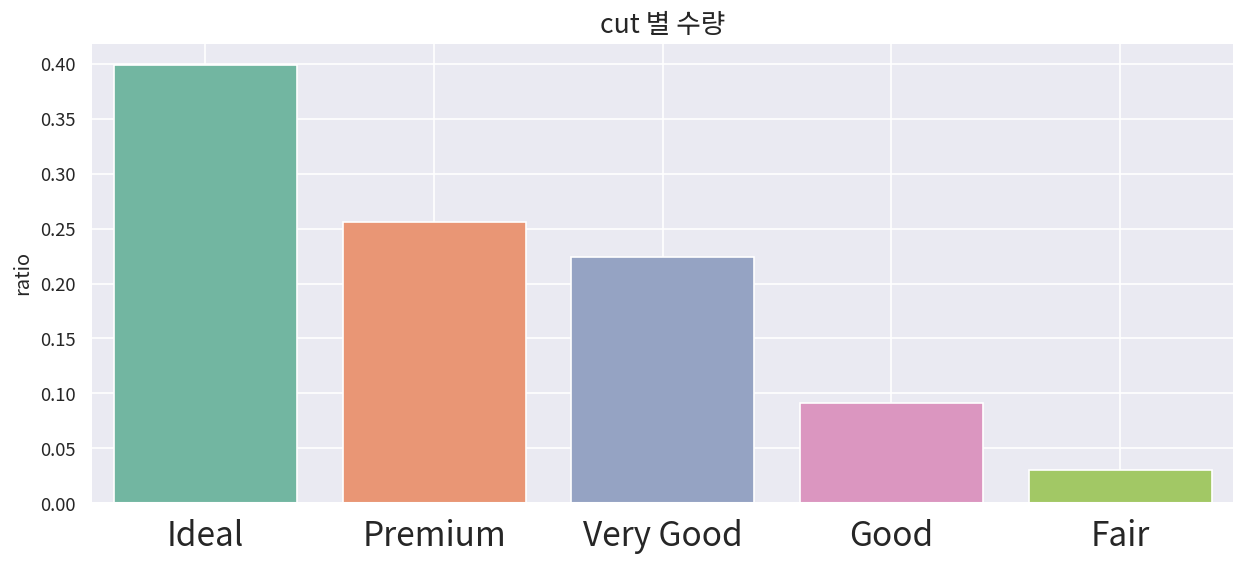

In [101]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 600              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=cut_df,           #사용할 데이터 프레임
    x='cut',        #막대의 카테고리축
    y='ratio',      #요약할 수치 변수  
    palette='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김
plt.xticks(fontsize=20)
ax.set_xlabel('')
ax.set_title('cut 별 수량', fontsize=16, fontweight='bold')

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<color 의 경우>

In [102]:
color_list = 컬럼타입변경df['color'].unique()

color_counts = []   # 개수 저장 리스트

for color in color_list:
    count = len(컬럼타입변경df.query('color == @color'))
    color_counts.append(count)

# 데이터프레임 생성
color_df = pd.DataFrame({
    'color': color_list,
    'count': color_counts
})

# 전체 개수
total = color_df['count'].sum()

# 비율 추가
color_df['ratio'] = color_df['count'] / total
color_df['percent'] = (color_df['ratio'] * 100).round(2)

color_df
    


,color,count,ratio,percent
0,E,9797,0.181628,18.16
1,I,5422,0.100519,10.05
2,J,2808,0.052058,5.21
3,H,8304,0.153949,15.39
4,F,9542,0.176900,17.69
5,G,11292,0.209344,20.93
6,D,6775,0.125603,12.56


C:\Users\itwill\AppData\Local\Temp\ipykernel_20276\1751062025.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


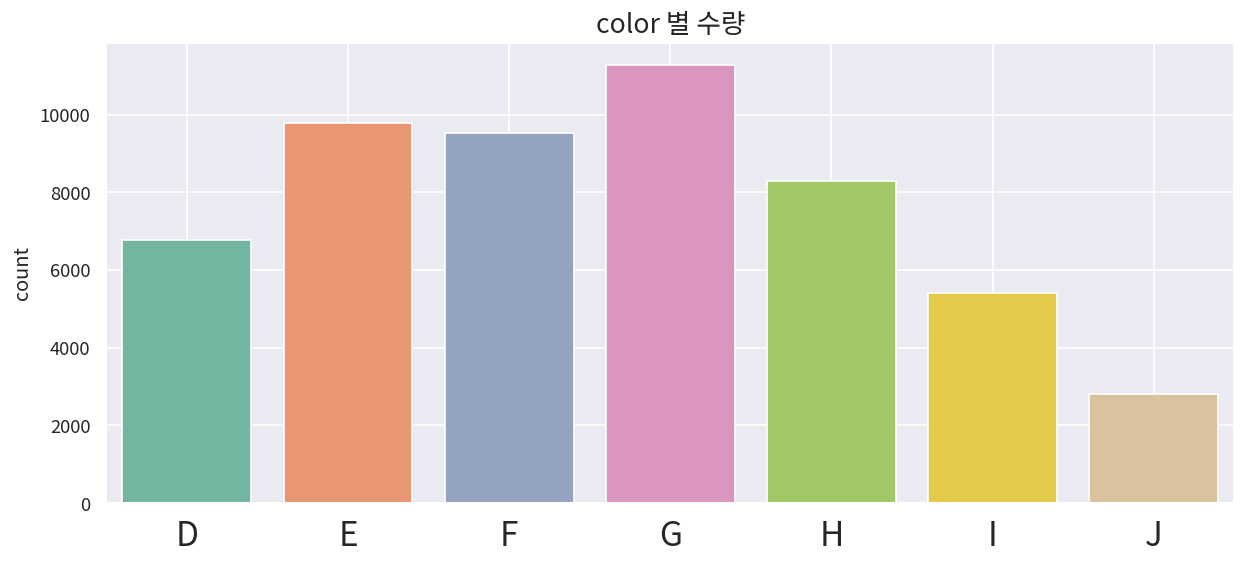

In [70]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 600              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=color_df,           #사용할 데이터 프레임
    x='color',        #막대의 카테고리축
    y='count',      #요약할 수치 변수  
    palette='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김
plt.xticks(fontsize=20)
ax.set_xlabel('')
ax.set_title('color 별 수량', fontsize=16, fontweight='bold')

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


<clarity 의 경우>

In [103]:
clarity_list = 컬럼타입변경df['clarity'].unique()

clarity_counts = []   # 개수 저장 리스트

for clarity in clarity_list:
    count = len(컬럼타입변경df.query('clarity == @clarity'))
    clarity_counts.append(count)

# 데이터프레임 생성
clarity_df = pd.DataFrame({
    'clarity': clarity_list,
    'count': clarity_counts
})

# 전체 개수
total = clarity_df['count'].sum()

# 비율 추가
clarity_df['ratio'] = clarity_df['count'] / total
clarity_df['percent'] = (clarity_df['ratio'] * 100).round(2)

clarity_df


,clarity,count,ratio,percent
0,SI2,9194,0.170449,17.04
1,SI1,13065,0.242214,24.22
2,VS1,8171,0.151483,15.15
3,VS2,12258,0.227253,22.73
4,VVS2,5066,0.093919,9.39
5,VVS1,3655,0.067760,6.78
6,I1,741,0.013737,1.37
7,IF,1790,0.033185,3.32


C:\Users\itwill\AppData\Local\Temp\ipykernel_20276\3701971750.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(


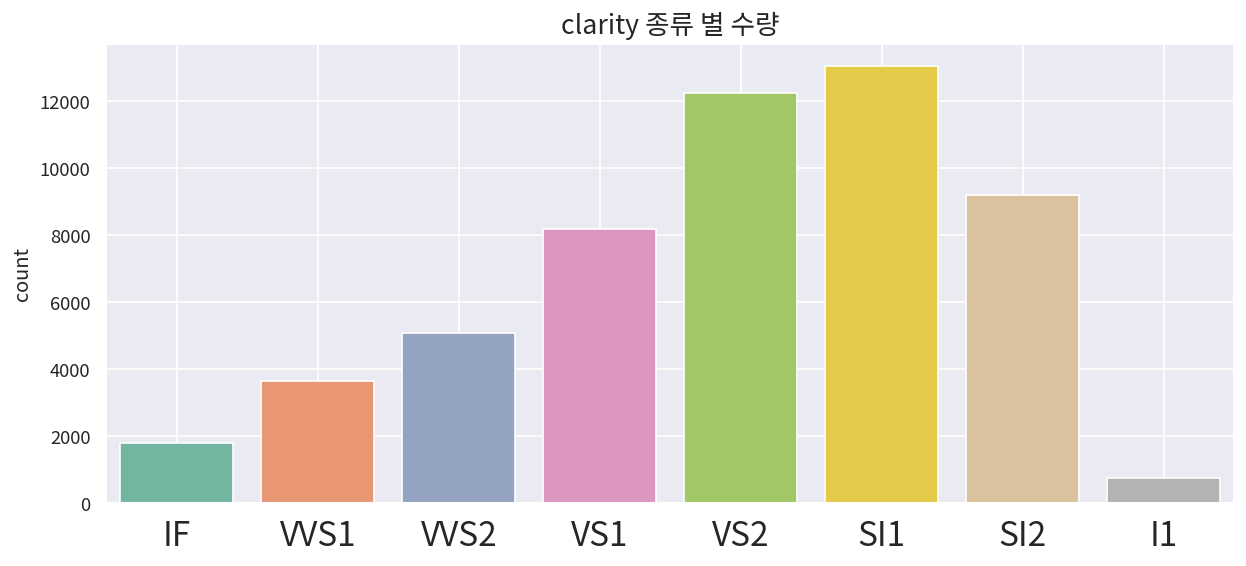

In [62]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 600              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) barplot 그리기
sb.barplot(
    data=clarity_df,           #사용할 데이터 프레임
    x='clarity',        #막대의 카테고리축
    y='count',      #요약할 수치 변수  
    palette='Set2'
)

# 3) 그래프 꾸미기
ax.grid(True)                          # 배경 격자 표시/숨김
plt.xticks(fontsize=20)
ax.set_xlabel('')
ax.set_title('clarity 종류 별 수량', fontsize=16, fontweight='bold')

# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


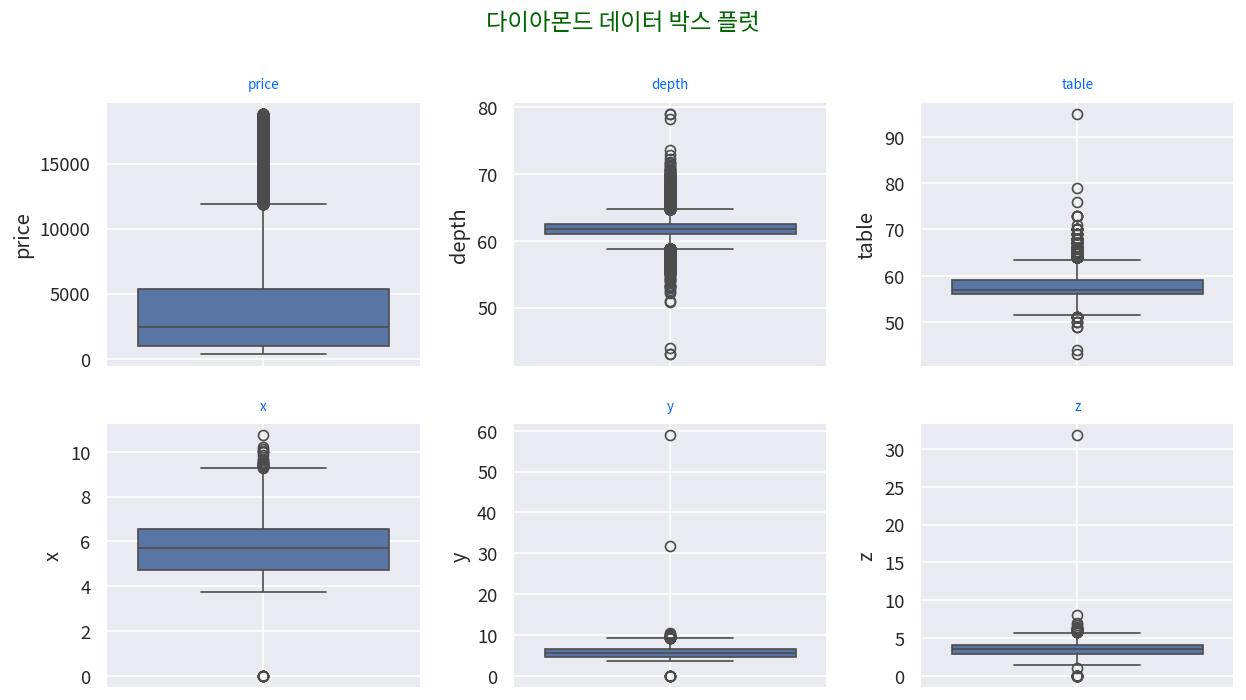

In [32]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 2                     # 그래프 행 수
cols = 3                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=컬럼타입변경df, y='price',ax=ax[0][0])
sb.boxplot(data=컬럼타입변경df, y='depth',ax=ax[0][1])
sb.boxplot(data=컬럼타입변경df, y='table',ax=ax[0][2])


sb.boxplot(data=컬럼타입변경df, y='x',ax=ax[1][0])
sb.boxplot(data=컬럼타입변경df, y='y',ax=ax[1][1])
sb.boxplot(data=컬럼타입변경df, y='z',ax=ax[1][2])


# 3) 그래프 꾸미기

#그래프 전체에 대한 제목
fig.suptitle('다이아몬드 데이터 박스 플럿',fontsize = 14 , color ='#006600')

#각 그래프 간의 가로 (wspace) , 세로 (hspace) 간격 지정
fig.subplots_adjust(wspace=0.2 , hspace=0.2)



# 그래프의 제목, 글자크기, 색상, 격자
ax[0][0].set_title("price", color="#0066ff", fontsize=8, pad=8)
ax[0][0].grid()

ax[0][1].set_title("depth", color="#0066ff", fontsize=8, pad=8)
ax[0][1].grid()


ax[0][2].set_title("table", color="#0066ff", fontsize=8, pad=8)
ax[0][2].grid()

ax[1][0].set_title("x", color="#0066ff", fontsize=8, pad=8)
ax[1][0].grid()

ax[1][1].set_title("y", color="#0066ff", fontsize=8, pad=8)
ax[1][1].grid()

ax[1][2].set_title("z", color="#0066ff", fontsize=8, pad=8)
ax[1][2].grid()



# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


- 0이 있는 행을 찾아보자

In [65]:
컬럼타입변경df.eq(0).sum()


price       0
carat       0
cut         0
color       0
clarity     0
x           8
y           7
z          20
depth       0
table       0
dtype: int64

In [66]:
zero_rows = 컬럼타입변경df[컬럼타입변경df.eq(0).any(axis=1)]
zero_columns = 컬럼타입변경df.eq(0).any()

zero_rows, zero_columns


(       price  carat        cut color clarity     x     y    z  depth  table
 2207    3142   1.00    Premium     G     SI2  6.55  6.48  0.0   59.1   59.0
 2314    3167   1.01    Premium     H      I1  6.66  6.60  0.0   58.1   59.0
 4791    3696   1.10    Premium     G     SI2  6.50  6.47  0.0   63.0   59.0
 5471    3837   1.01    Premium     F     SI2  6.50  6.47  0.0   59.2   58.0
 10167   4731   1.50       Good     G      I1  7.15  7.04  0.0   64.0   61.0
 11182   4954   1.07      Ideal     F     SI2  0.00  6.62  0.0   61.6   56.0
 11963   5139   1.00  Very Good     H     VS2  0.00  0.00  0.0   63.3   53.0
 13601   5564   1.15      Ideal     G     VS2  6.88  6.83  0.0   59.2   56.0
 15951   6381   1.14       Fair     G     VS1  0.00  0.00  0.0   57.5   67.0
 24394  12631   2.18    Premium     H     SI2  8.49  8.45  0.0   59.4   61.0
 24520  12800   1.56      Ideal     G     VS2  0.00  0.00  0.0   62.2   54.0
 26123  15397   2.25    Premium     I     SI1  8.52  8.42  0.0   61.3   58.0

> 개인적으로는 특정 colore, cut, clarity 에서만 결측치가 발생한 것이 아닌 랜덤으로 발생했다고 판단, 또한 크기가 0 인 경우가 전체의 0.03% 로 단순 제거해도 영향력은 크지 않을 것이라고 판단하여 단순 제거 선택

<이상치 (x,y,z 중 하나라도 0이 있는 경우) drop 결정>

In [68]:
df_clean = 컬럼타입변경df[(컬럼타입변경df[['x','y','z']] != 0).all(axis=1)]
df_clean

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0


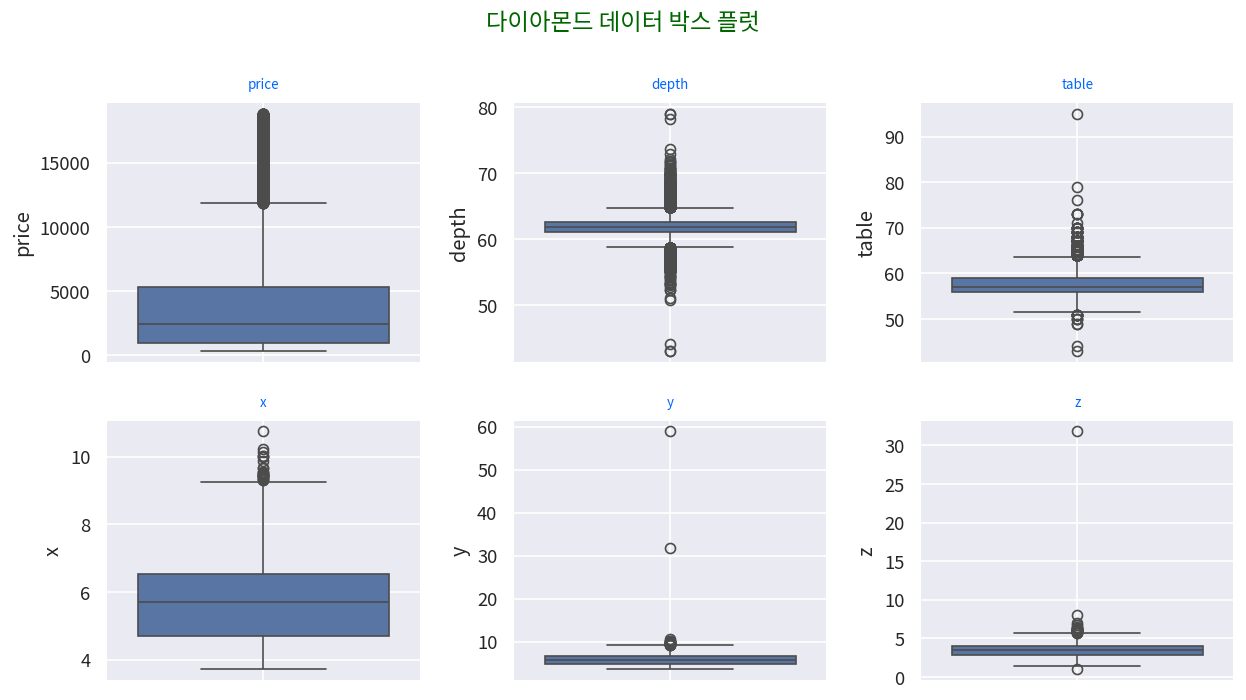

In [69]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 2                     # 그래프 행 수
cols = 3                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df_clean, y='price',ax=ax[0][0])
sb.boxplot(data=df_clean, y='depth',ax=ax[0][1])
sb.boxplot(data=df_clean, y='table',ax=ax[0][2])


sb.boxplot(data=df_clean, y='x',ax=ax[1][0])
sb.boxplot(data=df_clean, y='y',ax=ax[1][1])
sb.boxplot(data=df_clean, y='z',ax=ax[1][2])


# 3) 그래프 꾸미기

#그래프 전체에 대한 제목
fig.suptitle('다이아몬드 데이터 박스 플럿',fontsize = 14 , color ='#006600')

#각 그래프 간의 가로 (wspace) , 세로 (hspace) 간격 지정
fig.subplots_adjust(wspace=0.2 , hspace=0.2)


# 그래프의 제목, 글자크기, 색상, 격자
ax[0][0].set_title("price", color="#0066ff", fontsize=8, pad=8)
ax[0][0].grid()

ax[0][1].set_title("depth", color="#0066ff", fontsize=8, pad=8)
ax[0][1].grid()


ax[0][2].set_title("table", color="#0066ff", fontsize=8, pad=8)
ax[0][2].grid()

ax[1][0].set_title("x", color="#0066ff", fontsize=8, pad=8)
ax[1][0].grid()

ax[1][1].set_title("y", color="#0066ff", fontsize=8, pad=8)
ax[1][1].grid()

ax[1][2].set_title("z", color="#0066ff", fontsize=8, pad=8)
ax[1][2].grid()



# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


> x,y,z 중 0이 있는 값을 제거한 후의 박스 플럿, 여전히 이상치들이 다수 확인되고 있다


- cut의 종류 ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
- color 의 종류 ['E' 'I' 'J' 'H' 'F' 'G' 'D']
- clarity 의 종류 ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

In [84]:


df_clean_cut_Ideal = df_clean.query("cut =='Ideal'")
df_clean_cut_Premium = df_clean.query("cut =='Premium'")
df_clean_cut_Good = df_clean.query("cut =='Good'")
df_clean_cut_Very_Good = df_clean.query("cut =='Very Good'")
df_clean_cut_Fair = df_clean.query("cut =='Fair'")


cut_df_list = [df_clean_cut_Ideal,df_clean_cut_Premium,df_clean_cut_Good,df_clean_cut_Very_Good,df_clean_cut_Fair]

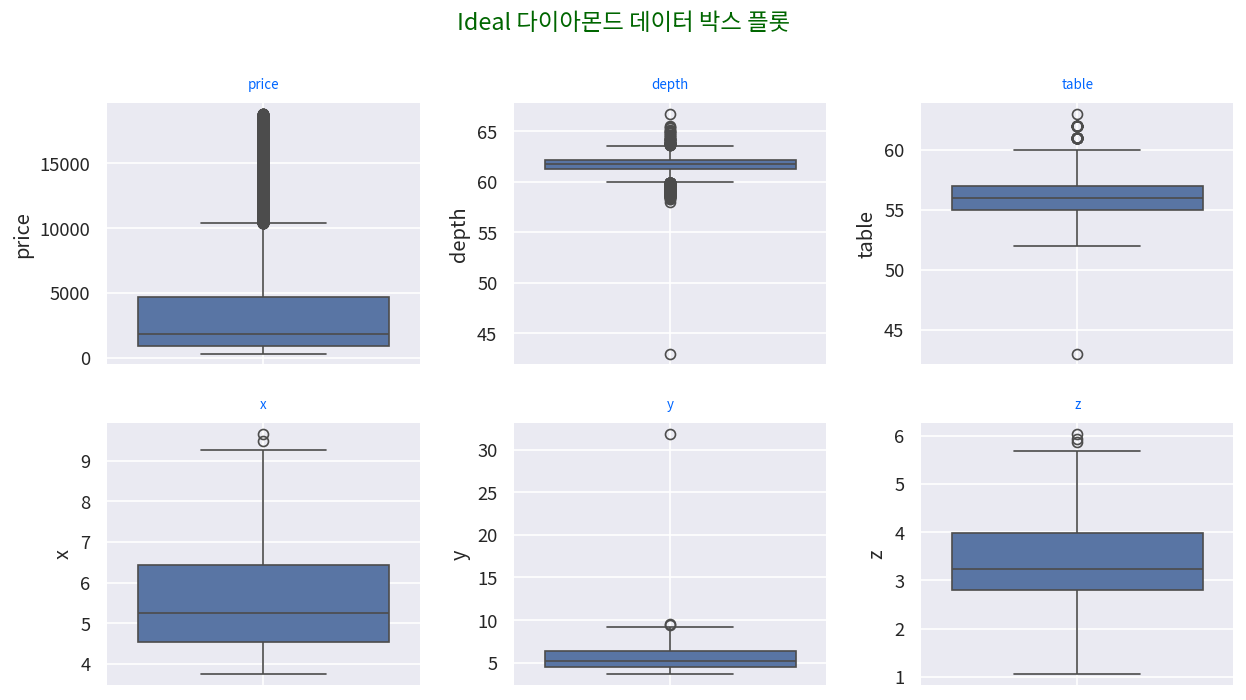

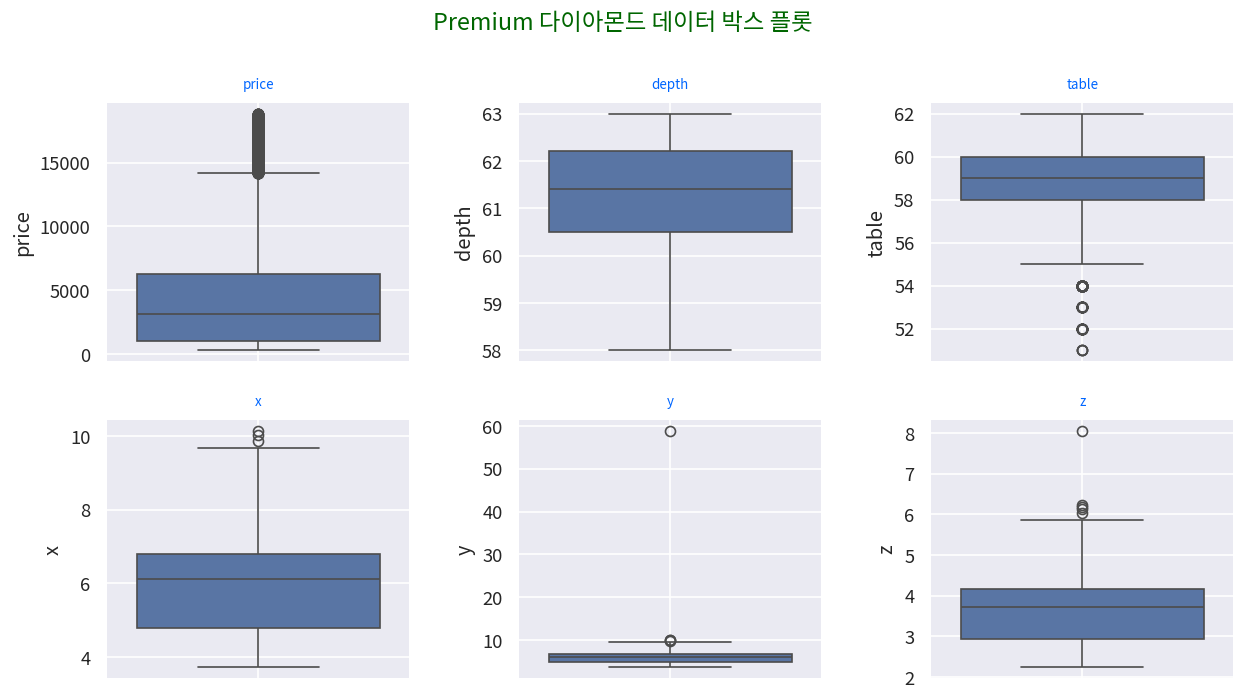

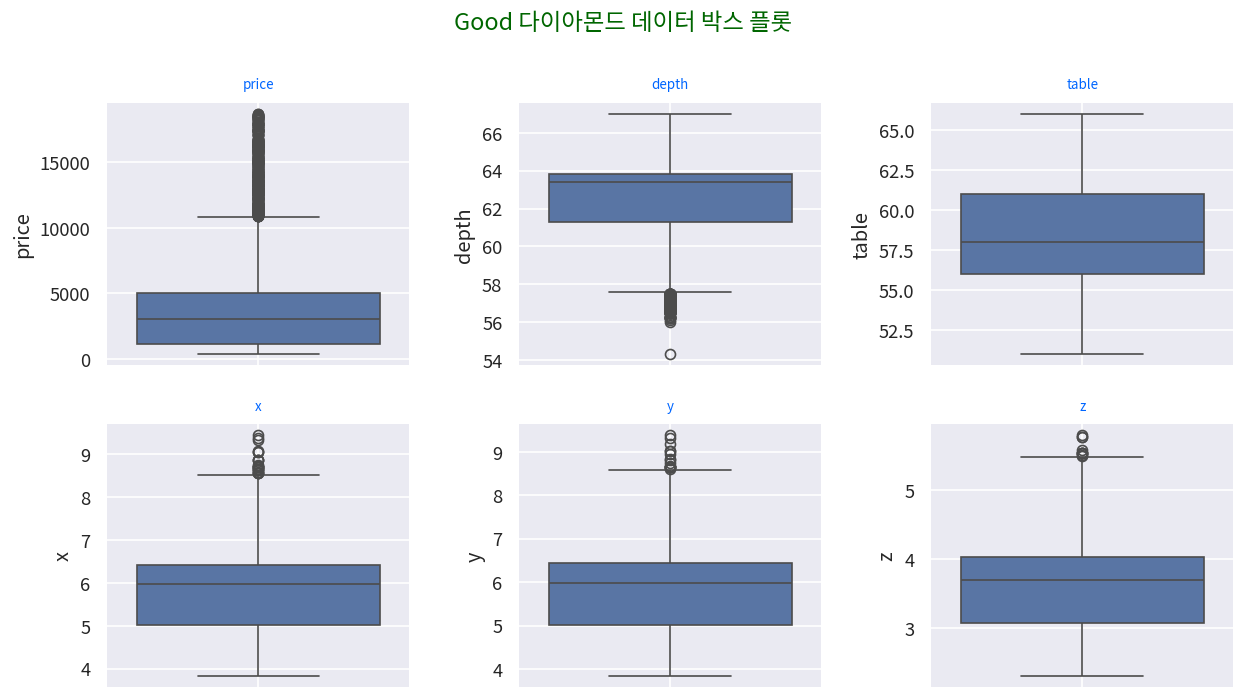

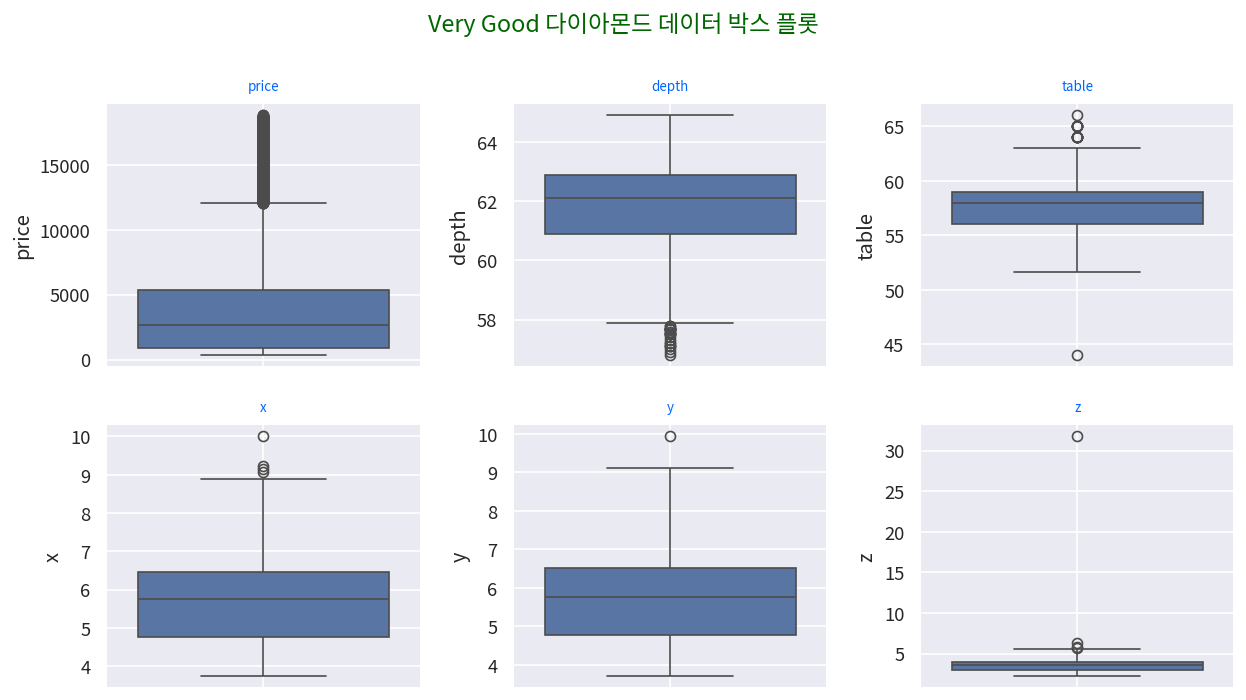

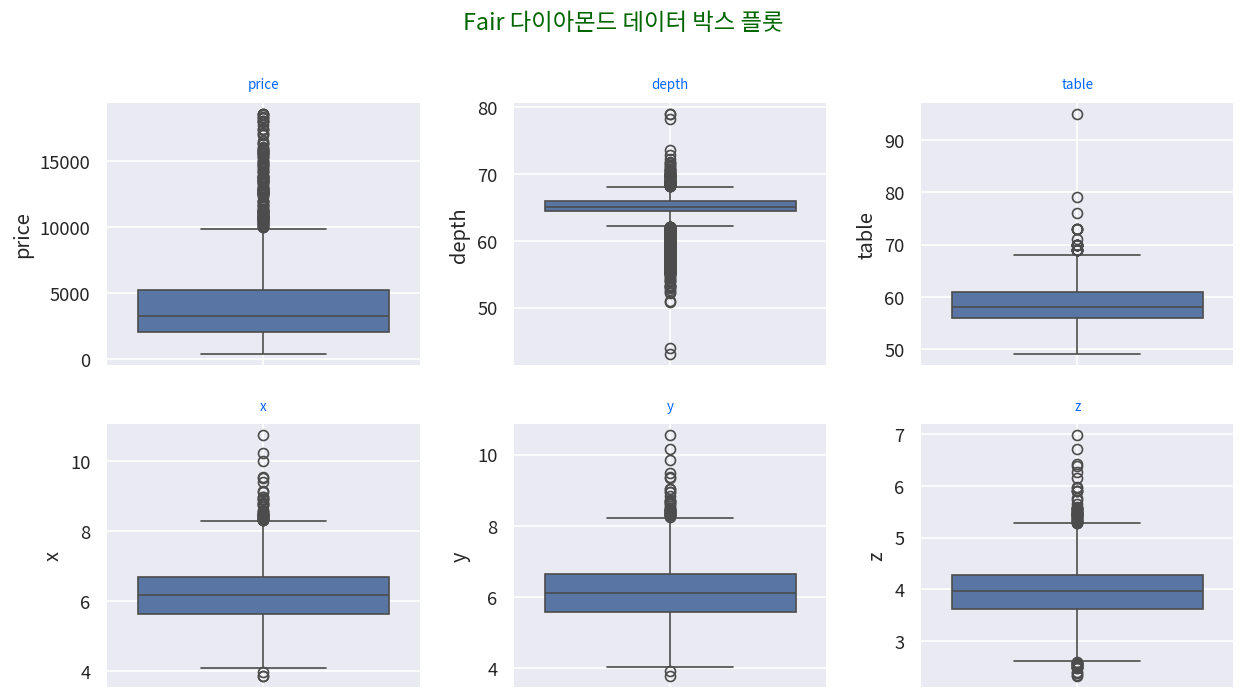

In [90]:
for i in cut_df_list:

  # 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
  width_px = 1280              # 그래프 가로 크기
  height_px = 720              # 그래프 세로 크기
  rows = 2                     # 그래프 행 수
  cols = 3                     # 그래프 열 수
  figsize = (width_px / my_dpi, height_px / my_dpi)
  fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

  # 2) 그래프 그리기 -> seaborn 사용
  sb.boxplot(data=i, y='price',ax=ax[0][0])
  sb.boxplot(data=i, y='depth',ax=ax[0][1])
  sb.boxplot(data=i, y='table',ax=ax[0][2])


  sb.boxplot(data=i, y='x',ax=ax[1][0])
  sb.boxplot(data=i, y='y',ax=ax[1][1])
  sb.boxplot(data=i, y='z',ax=ax[1][2])


  # 3) 그래프 꾸미기

  #그래프 전체에 대한 제목
  fig.suptitle(f'{i['cut'].iloc[0]} 다이아몬드 데이터 박스 플롯', fontsize=14, color='#006600')


  #각 그래프 간의 가로 (wspace) , 세로 (hspace) 간격 지정
  fig.subplots_adjust(wspace=0.2 , hspace=0.2)

  # 그래프의 제목, 글자크기, 색상, 격자
  ax[0][0].set_title("price", color="#0066ff", fontsize=8, pad=8)
  ax[0][0].grid()

  ax[0][1].set_title("depth", color="#0066ff", fontsize=8, pad=8)
  ax[0][1].grid()


  ax[0][2].set_title("table", color="#0066ff", fontsize=8, pad=8)
  ax[0][2].grid()

  ax[1][0].set_title("x", color="#0066ff", fontsize=8, pad=8)
  ax[1][0].grid()

  ax[1][1].set_title("y", color="#0066ff", fontsize=8, pad=8)
  ax[1][1].grid()

  ax[1][2].set_title("z", color="#0066ff", fontsize=8, pad=8)
  ax[1][2].grid()



  # 4) 출력
  plt.tight_layout()                     # 여백 제거
  plt.show()                             # 그래프 화면 출력
  plt.close()                            # 그래프 작업 종료


In [91]:
df_clean['volume'] = df_clean['x'] * df_clean['y'] * df_clean['z']
df_clean


C:\Users\itwill\AppData\Local\Temp\ipykernel_20276\2142710490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['volume'] = df_clean['x'] * df_clean['y'] * df_clean['z']


,price,carat,cut,color,clarity,x,y,z,depth,table,volume
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,38.202030
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,34.505856
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,38.076885
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,46.724580
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,51.917250
...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0,115.920000
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0,118.110175
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0,114.449728
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0,140.766120


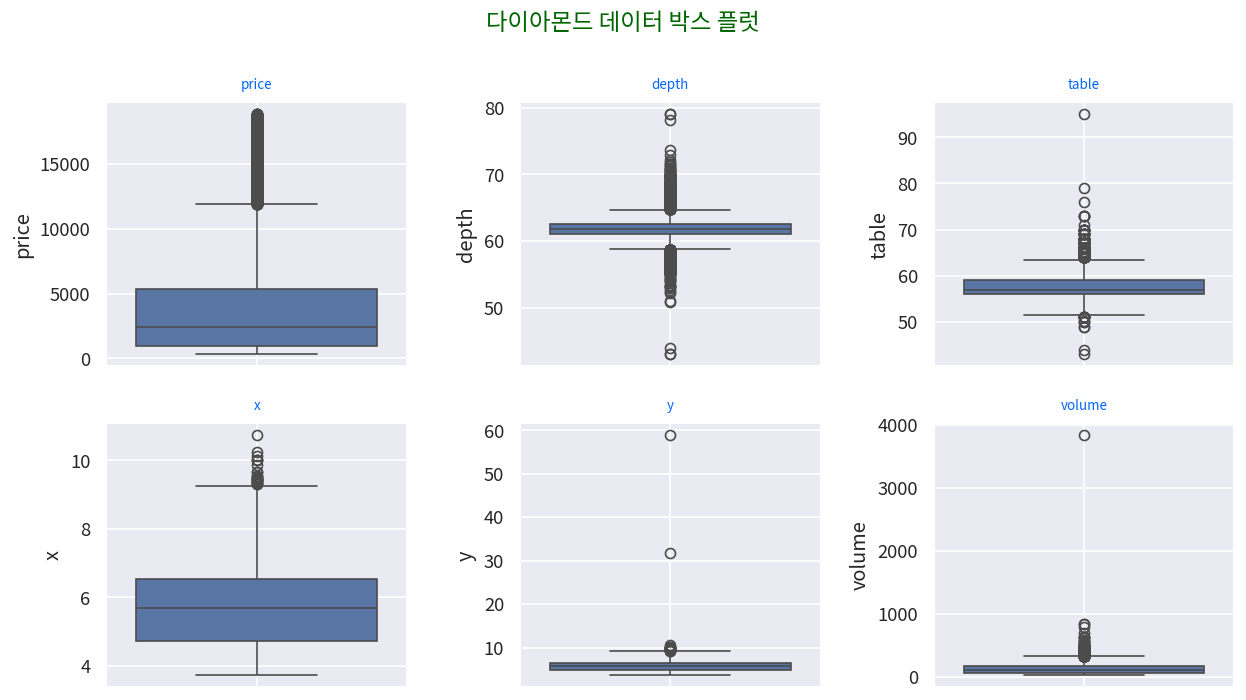

In [99]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 2                     # 그래프 행 수
cols = 3                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df_clean, y='price',ax=ax[0][0])
sb.boxplot(data=df_clean, y='depth',ax=ax[0][1])
sb.boxplot(data=df_clean, y='table',ax=ax[0][2])


sb.boxplot(data=df_clean, y='x',ax=ax[1][0])
sb.boxplot(data=df_clean, y='y',ax=ax[1][1])
sb.boxplot(data=df_clean, y='volume',ax=ax[1][2])


# 3) 그래프 꾸미기

#그래프 전체에 대한 제목
fig.suptitle('다이아몬드 데이터 박스 플럿',fontsize = 14 , color ='#006600')

#각 그래프 간의 가로 (wspace) , 세로 (hspace) 간격 지정
fig.subplots_adjust(wspace=0.2 , hspace=0.2)


# 그래프의 제목, 글자크기, 색상, 격자
ax[0][0].set_title("price", color="#0066ff", fontsize=8, pad=8)
ax[0][0].grid()


ax[0][1].set_title("depth", color="#0066ff", fontsize=8, pad=8)
ax[0][1].grid()


ax[0][2].set_title("table", color="#0066ff", fontsize=8, pad=8)
ax[0][2].grid()

ax[1][0].set_title("x", color="#0066ff", fontsize=8, pad=8)
ax[1][0].grid()

ax[1][1].set_title("y", color="#0066ff", fontsize=8, pad=8)
ax[1][1].grid()

ax[1][2].set_title("volume", color="#0066ff", fontsize=8, pad=8)
ax[1][2].grid()



# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


> volume 이 1000 이상 넘는 값 제거

In [94]:
df_clean_copy = df_clean.copy()
df_clean_copy

,price,carat,cut,color,clarity,x,y,z,depth,table,volume
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,38.202030
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,34.505856
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,38.076885
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,46.724580
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,51.917250
...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0,115.920000
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0,118.110175
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0,114.449728
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0,140.766120


In [96]:
df_clean_copy_drop = df_clean_copy[df_clean_copy['volume'] <= 1000]


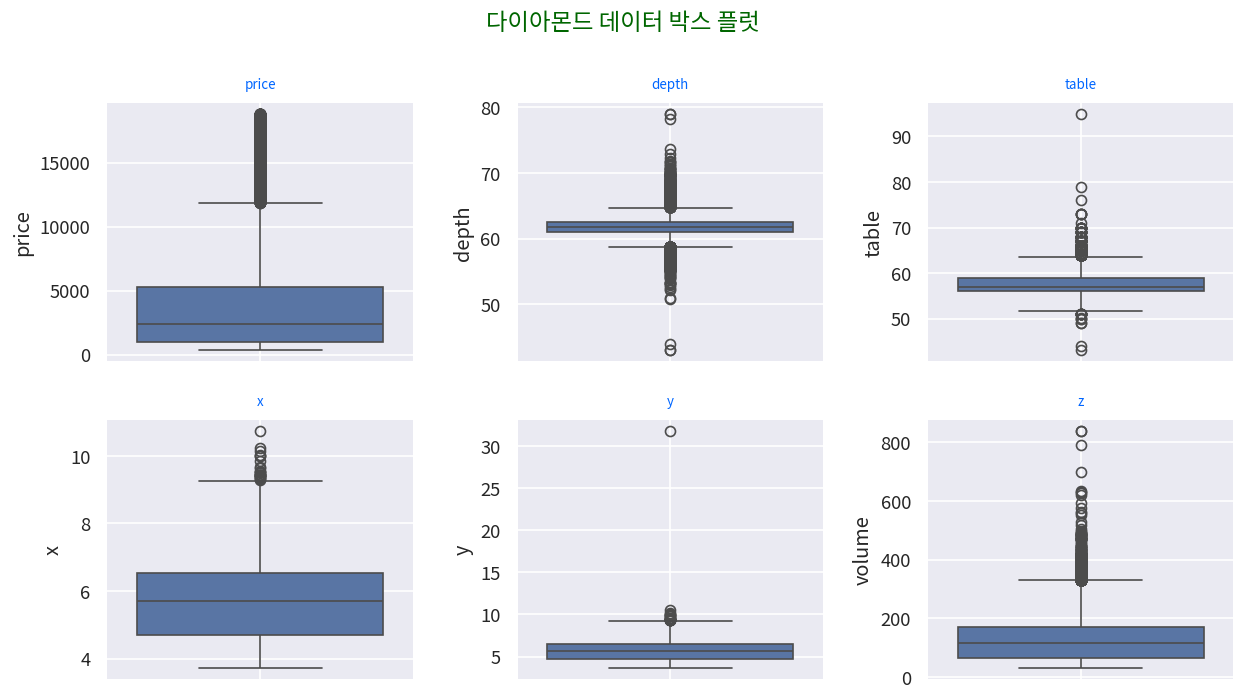

In [97]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 2                     # 그래프 행 수
cols = 3                     # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df_clean_copy_drop, y='price',ax=ax[0][0])
sb.boxplot(data=df_clean_copy_drop, y='depth',ax=ax[0][1])
sb.boxplot(data=df_clean_copy_drop, y='table',ax=ax[0][2])


sb.boxplot(data=df_clean_copy_drop, y='x',ax=ax[1][0])
sb.boxplot(data=df_clean_copy_drop, y='y',ax=ax[1][1])
sb.boxplot(data=df_clean_copy_drop, y='volume',ax=ax[1][2])


# 3) 그래프 꾸미기

#그래프 전체에 대한 제목
fig.suptitle('다이아몬드 데이터 박스 플럿',fontsize = 14 , color ='#006600')

#각 그래프 간의 가로 (wspace) , 세로 (hspace) 간격 지정
fig.subplots_adjust(wspace=0.2 , hspace=0.2)

# 그래프의 제목, 글자크기, 색상, 격자
ax[0][0].set_title("price", color="#0066ff", fontsize=8, pad=8)
ax[0][0].grid()

ax[0][1].set_title("depth", color="#0066ff", fontsize=8, pad=8)
ax[0][1].grid()


ax[0][2].set_title("table", color="#0066ff", fontsize=8, pad=8)
ax[0][2].grid()

ax[1][0].set_title("x", color="#0066ff", fontsize=8, pad=8)
ax[1][0].grid()

ax[1][1].set_title("y", color="#0066ff", fontsize=8, pad=8)
ax[1][1].grid()

ax[1][2].set_title("volume", color="#0066ff", fontsize=8, pad=8)
ax[1][2].grid()



# 4) 출력
plt.tight_layout()                     # 여백 제거
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


[미션 1 정리]
- 데이터들은 모두 non -null 로 결측치는 없었으나, 0이 될 수 없는 값 x,y,z 에 0 이 발견되어 해당 값들은 단순 제거로 처리했음 > 전체 데이터의 1% 미만이었고 특정 colore, cut, clarity 에서만 결측치가 발생한 것이 아닌 랜덤으로 발생했다고 판단



-x,y,z 의 곱을 volume 컬럼이라 추가하고, volume 이 1000을 넘는 경우는 제거함
(x,y,z, 에서 이상치가 다수 존재하는데 다 제거할 수는 없고, 세 값을 골고루 조회했을 떄의 값을 봐야한다고 생각했음)

- cut의 종류는 5개 
  cut의 종류:
['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']


- color 의 종류는 7개
  color의 종류:
  ['E', 'I', 'J', 'H', 'F', 'G', 'D']

- clarity 의 종류는 8개
  clarity의 종류:
  ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

### 미션 2
- 가격 데이터는 어떤 모습일까

<price>

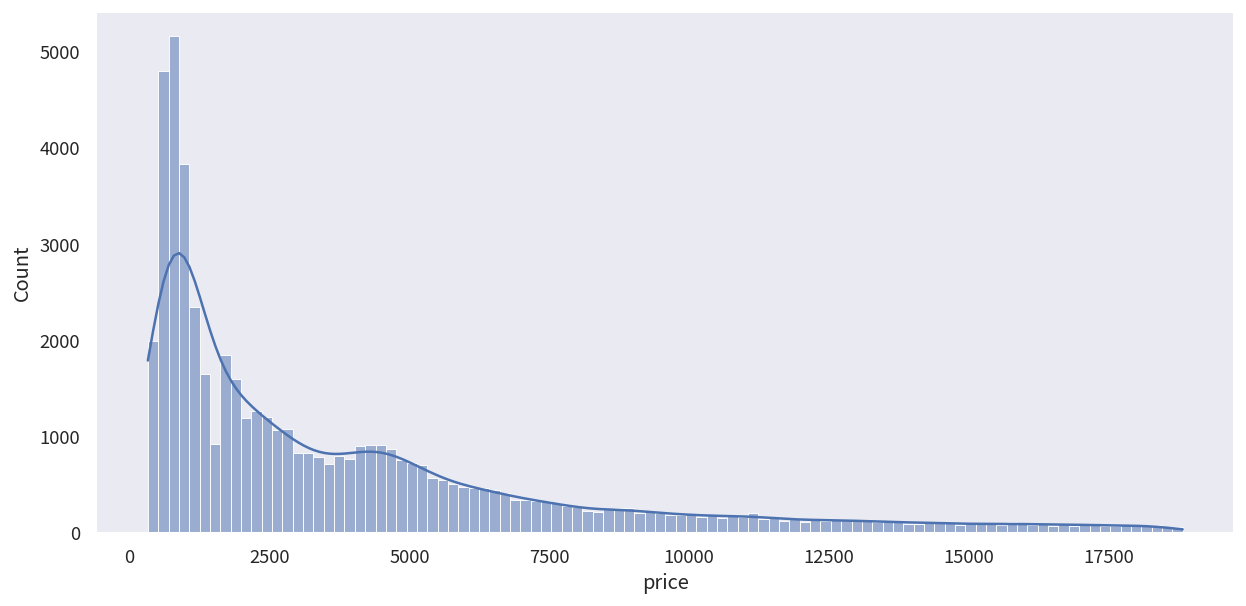

In [110]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=1                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_clean_copy_drop['price'],bins=100, kde = True)

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

<carat>

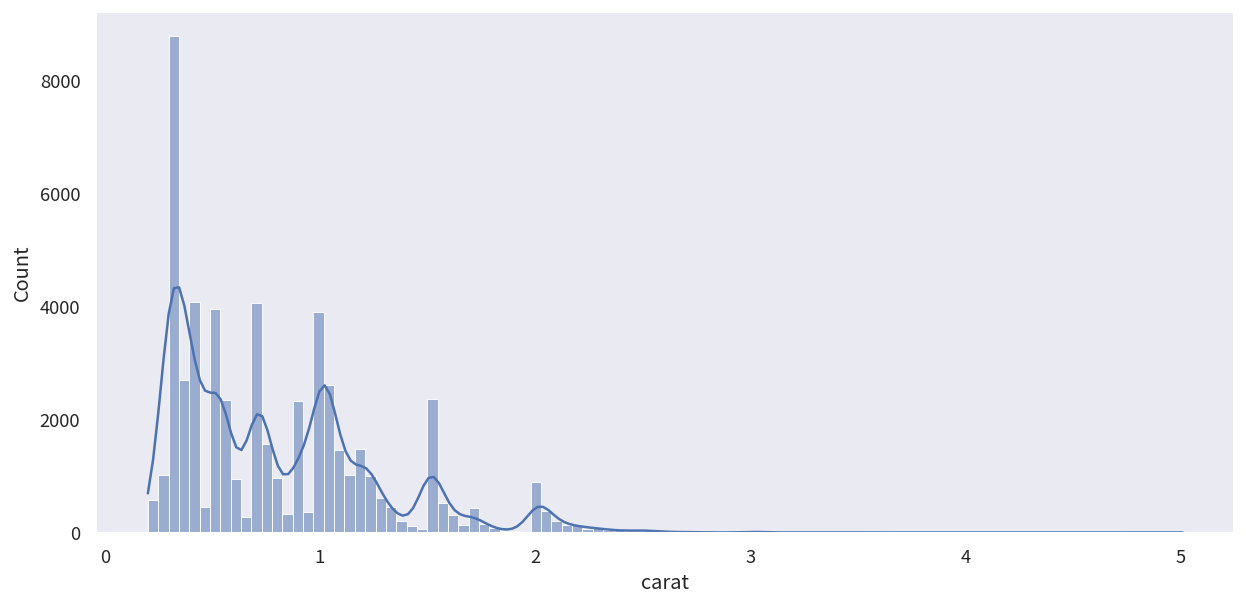

In [109]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=1                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_clean_copy_drop['carat'],bins=100, kde = True)

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

<price 와 carat 변수의 공통점과 차이점>
- 공통점
  1. 정규분포를 따르지 않는다
  2. 약 하위 10% 구간에 대부분의 값이 집중되어 있다
  


- 차이점
  1. price 는 높아질수록 그 수가 줄어드는 경향을 보였으나, carat 은 하위 10% 이외의 구간에서도 중간 중간 높은 지점들이 있었다



> 해당 분포로는 분석 진행이 적합하지 않다고 판단


### 미션 3. 로그 변환은 왜 등장할까?

In [112]:
import numpy as np
df_log = df_clean_copy_drop.copy()

df_log['log_price'] = np.log1p(df_log['price'])
df_log['log_carat'] = np.log1p(df_log['carat'])


In [113]:
df_log

,price,carat,cut,color,clarity,x,y,z,depth,table,volume,log_price,log_carat
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,38.202030,5.789960,0.207014
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,34.505856,5.789960,0.190620
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,38.076885,5.793014,0.207014
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,46.724580,5.814131,0.254642
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,51.917250,5.817111,0.270027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0,115.920000,7.922261,0.542324
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0,118.110175,7.922261,0.542324
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0,114.449728,7.922261,0.530628
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0,140.766120,7.922261,0.620576


<log 변환 후의 price>

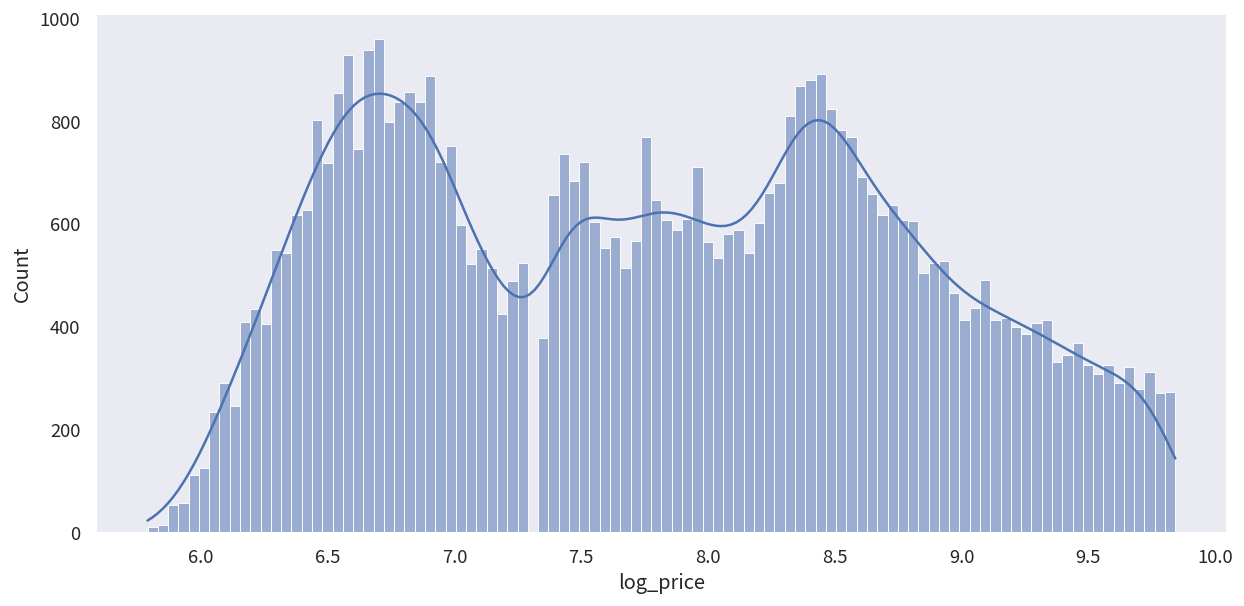

In [115]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=1                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_log['log_price'],bins=100, kde = True)

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

<log 변환 후의 carat>

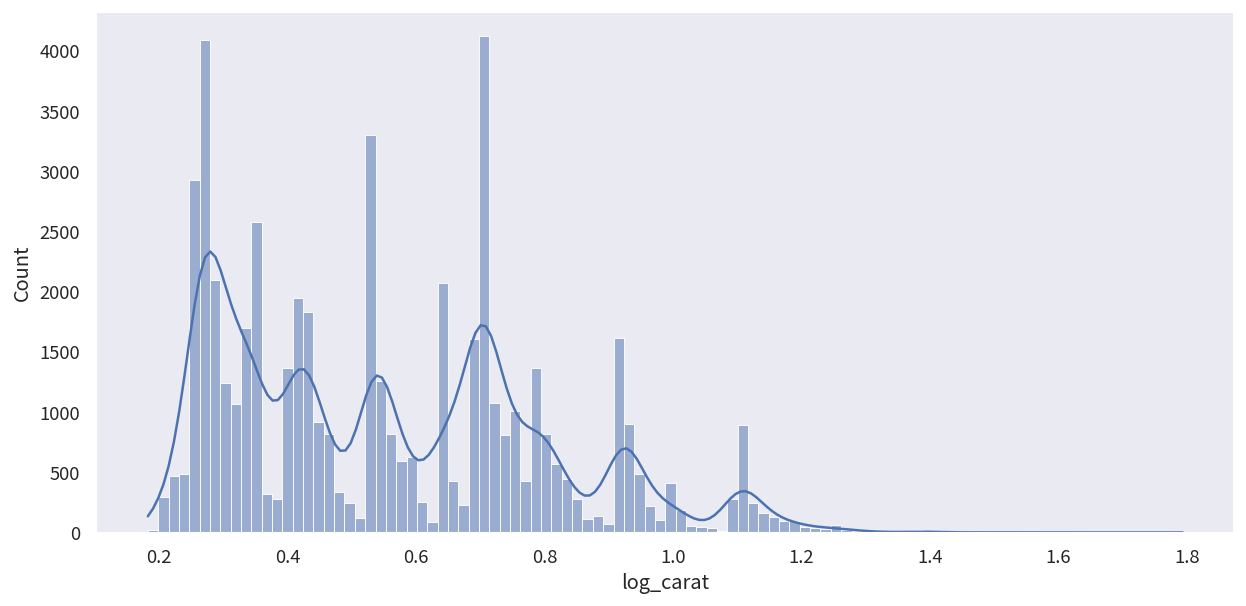

In [116]:
#1) 그래프 초기화 (캔바스 fig 와 도화지 ax 준비하기)
width_px=1280           #그래프 가로 크기
height_px = 640         #그래프 세로 크기
rows=1                  # 도화지 행 수
cols=1                  # 도화지 열 수
figsize =(width_px/my_dpi, height_px/my_dpi)
fig,ax = plt.subplots(rows,cols,figsize=figsize,dpi = my_dpi)


#2) 그래프 그리기 > seaborn 사용
sb.histplot(data=df_log['log_carat'],bins=100, kde = True)

#3) 출력                        
plt.tight_layout()                    #여백 제거
plt.show()                            #그래프 화면 출력
plt.close()                           #그래프 작업 종료

> log 변환 후 좌측에만 치우쳐져 있던 데이터들이 골고루 퍼졌다. 여전히 정규분포를 띄고있지는 않지만, 너무 작았던 값은 확대해주면서 이전보다는 균형있 데이터 형태로 변환했다

### 미션 4. 품질 등급은 가격을 얼마나 설명해줄까?
cut, color, clarity에 따라 다이아몬드 가격 분포가 어떻게 달라지는지 시각화해 보자.
중앙값, 분산, 분포의 겹침 정도를 관찰하며 다음 질문에 답해 보자.

- 어떤 품질 변수는 가격 차이가 뚜렷한가?
- 어떤 경우에는 등급이 달라도 가격이 크게 겹치는가?
- 숫자보다 패턴과 느낌을 중심으로 정리해 보자.


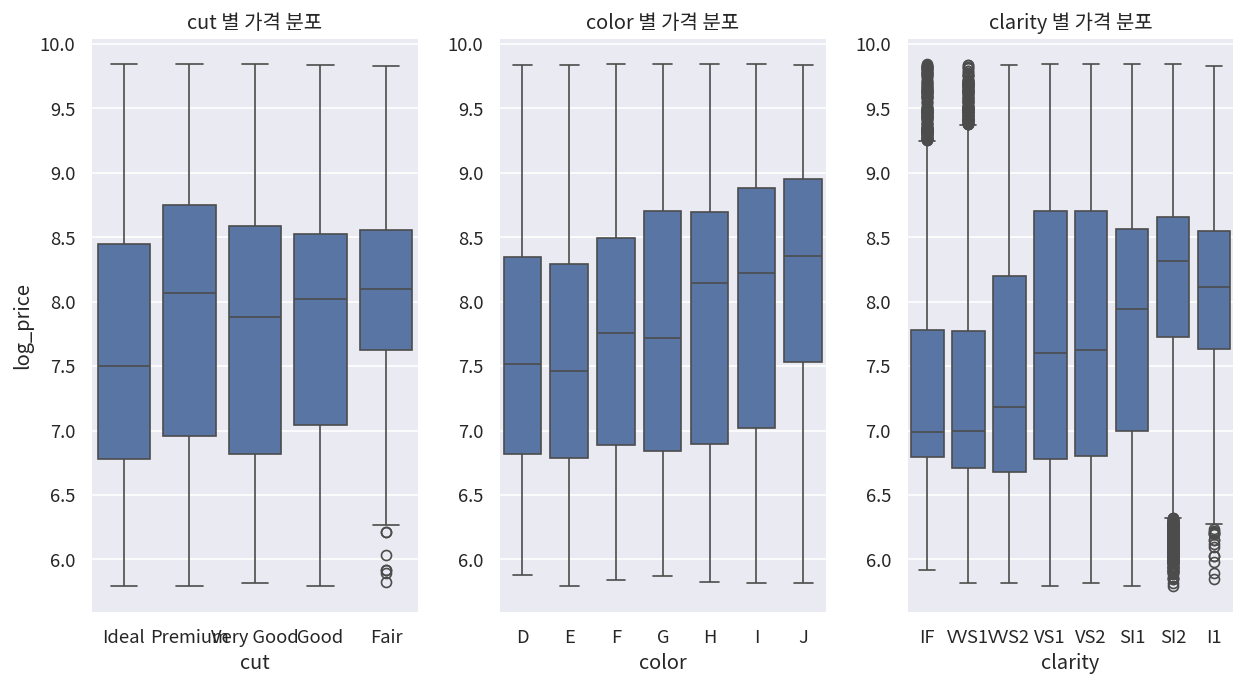

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# 사용할 데이터프레임와 컬럼 이름 (log_price 기준으로 예시)
df = df_clean_copy_drop   # 혹은 df_log
y_col = 'log_price'       # 로그 안 썼으면 'price'

width_px  = 1280
height_px = 720
figsize   = (width_px / my_dpi, height_px / my_dpi)

fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=my_dpi)

# 1) cut vs price
sns.boxplot(data=df_log, x='cut', y=y_col, ax=axes[0])
axes[0].set_title('cut 별 가격 분포')
axes[0].set_xlabel('cut')
axes[0].set_ylabel(y_col)

# 2) color vs price
sns.boxplot(data=df_log, x='color', y=y_col, ax=axes[1])
axes[1].set_title('color 별 가격 분포')
axes[1].set_xlabel('color')
axes[1].set_ylabel('')

# 3) clarity vs price
sns.boxplot(data=df_log, x='clarity', y=y_col, ax=axes[2])
axes[2].set_title('clarity 별 가격 분포')
axes[2].set_xlabel('clarity')
axes[2].set_ylabel('')

for ax in axes:
    ax.grid(True, axis='y')

plt.tight_layout()
plt.show()


> color는 가격 차이를 가장 뚜렷하게 설명한다.  
등급이 나빠질수록 가격이 전반적으로 상승하는 일관된 패턴을 보인다.

cut은 등급이 달라도 가격이 거의 비슷하게 나타나며, 품질 구분의 힘이 약하다.

clarity는 저등급(I1, SI2)과 고등급(IF) 사이 차이는 있지만  
중간 등급들(VS1/VS2/ VVS1/ VVS2)은 서로 가격이 겹쳐서 구분이 어렵다.

따라서 품질 등급 중 가격 설명력이 가장 강한 변수는 color이며,  
cut과 clarity는 등급 간 분포가 많이 겹쳐 가격 구분 능력이 다소 떨어진다.


### #미션 5 'Premium 컷은 정말 더 비쌀까?"

다음과 같은 질문을 통계적으로 검증해 보자.
Premium 컷 다이아몬드는 Ideal 컷보다 평균 가격이 높을까?
이를 위해 - 가설을 직접 세우고 - 어떤 검정 방법이 적절한지 고민한 뒤 - 실제로 검정을 수행해 보자.
검정 결과를 해석할 때는 “유의하다 / 유의하지 않다”에서 멈추지 말고, 이 차이가 얼마나 의미 있는 차이인지까지 함께 생각해 보자.



- 필요한 데이터만 가져온다

In [127]:
df_log.filter(['cut', 'log_price'])


,cut,log_price
0,Ideal,5.789960
1,Premium,5.789960
2,Good,5.793014
3,Premium,5.814131
4,Good,5.817111
...,...,...
53935,Ideal,7.922261
53936,Good,7.922261
53937,Very Good,7.922261
53938,Premium,7.922261


In [136]:
# 1) color와 log_price만 먼저 가져오기 (원하면 생략해도 됨)
tmp = df_log[['cut', 'log_price']].copy()

# 2) color 안에서 순번 붙이기 (0,1,2,...)
tmp['idx'] = tmp.groupby('cut').cumcount()

# 3) idx를 행, color를 열로 pivot
df_wide = tmp.pivot(index='idx', columns='cut', values='log_price')

df_wide.head(10)


C:\Users\itwill\AppData\Local\Temp\ipykernel_20276\665932998.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp['idx'] = tmp.groupby('cut').cumcount()


cut,Ideal,Premium,Very Good,Good,Fair
idx,,,,,
0,5.789960,5.789960,5.820083,5.793014,5.823046
1,5.831882,5.814131,5.820083,5.817111,7.922261
2,5.843544,5.837730,5.823046,5.828946,7.922986
3,5.855072,5.846439,5.826000,5.863631,7.924072
4,6.001415,5.846439,5.863631,5.863631,7.924072
5,6.001415,5.874931,5.866468,5.863631,7.924434
6,6.001415,6.001415,5.869297,5.998937,7.924434
7,6.003887,6.003887,5.869297,5.998937,7.929487
8,6.003887,6.003887,5.869297,5.998937,7.931285


<신뢰구간 확인>

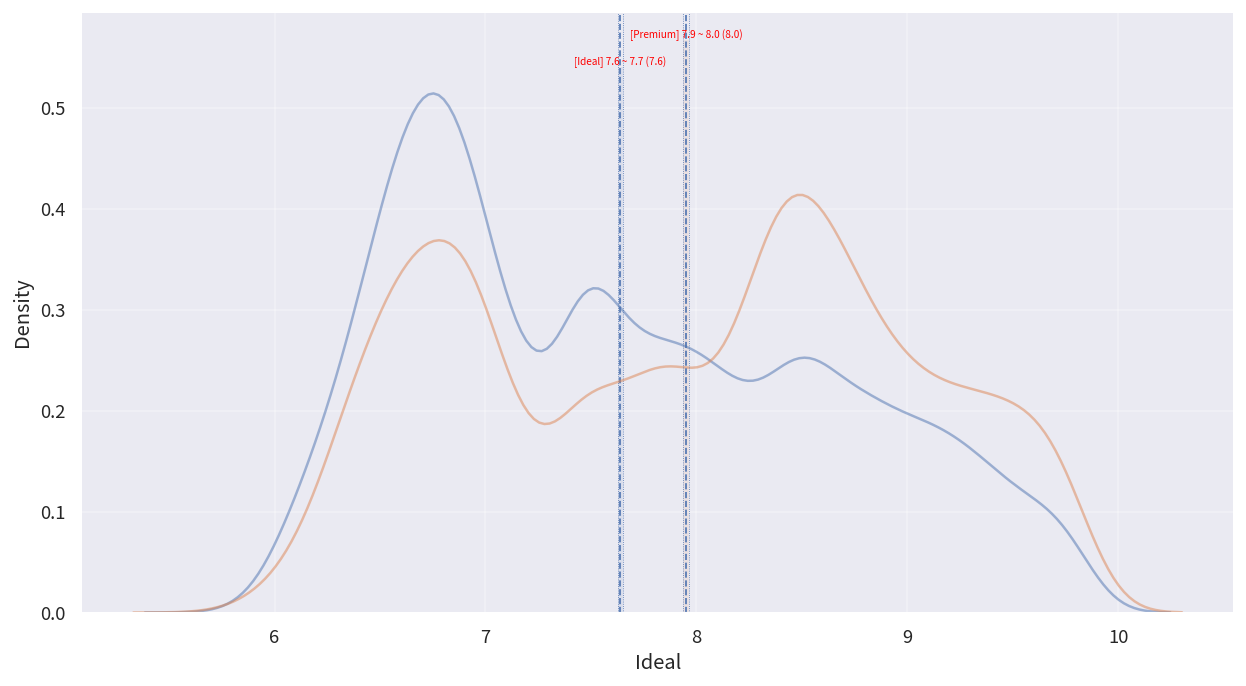

In [137]:
data = df_wide[['Ideal','Premium']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


> 두 그룹의 커널 밀도 함수 그래프 모양이 정규분포를 띄고 있지 않으며, 두 그룹의 분포는 상이하다. 또한 두 그룹 모두 표본 평균이 신뢰구간에 포함되어 있으므로 데이터는 정상 범위에 있다고 할 수 있다.

<가설검정의 가정 확인>

In [145]:
data = df_wide[['Ideal','Premium']]                      # 검사하려는 데이터 추출

# 0) NaN 제거된 데이터 따로 만들기
clean = {c: data[c].dropna() for c in data.columns}

equal_var_fields = []
normal_dist = True
report = []

# 1) 각 컬럼 정규성 검정
for c in clean.keys():
    s, p = normaltest(clean[c])   # NaN 제거된 시리즈 사용

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 2) 변수가 두 개 이상인 경우 등분산성 확인
if len(clean.keys()) > 1:
    # 모든 컬럼 데이터를 리스트로 모음 (각각 NaN 제거됨)
    arrays = [clean[c].values for c in clean.keys()]

    if normal_dist:
        n = "Bartlett"                      # 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*arrays)
    else:
        n = "Levene"                        # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*arrays, center='median')

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
Ideal,4625.405836,0.000000e+00,False
Premium,9974.910131,0.000000e+00,False
Levene,73.094405,1.284824e-17,False


> 정규성과 등분산성 검정 결과, 두 집단 모두 정규분포를 따르지 않고
분산도 동일하지 않아 독립표본 t-test의 전제조건을 충족하지 못하였다.
따라서 평균 차이 검정 대신, 분포의 위치 차이를 비교하는
비모수 검정인 Mann–Whitney U-test를 사용하였다.

> Mann–Whitney U-test는 평균 차이를 직접 검정하지는 않지만,
한 집단의 가격 분포가 다른 집단보다 전반적으로 더 큰지(더 높은 위치를 가지는지)
통계적으로 비교할 수 있는 적절한 방법이다.


In [149]:
ideal = df_log[df_log['cut'] == 'Ideal']['log_price']
premium = df_log[df_log['cut'] == 'Premium']['log_price']

from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(premium, ideal, alternative='two-sided')
print("U statistic:", stat)
print("p-value:", p)


U statistic: 174057986.5
p-value: 4.1550228217548527e-165


귀무가설(H0): Premium 컷 다이아몬드와 Ideal 컷 다이아몬드는 가격 분포의 위치가 동일하다.

대립가설(H1): Premium 컷과 Ideal 컷 다이아몬드는 가격 분포의 위치가 서로 다르다.


In [151]:
stat, p = mannwhitneyu(premium, ideal, alternative='greater')
print("U statistic:", stat)
print("p-value:", p)


U statistic: 174057986.5
p-value: 2.0775114108774263e-165


귀무가설(H0): Premium 컷 다이아몬드의 가격 분포는 Ideal 컷보다 크지 않다.

대립가설(H1): Premium 컷 다이아몬드의 가격 분포는 Ideal 컷보다 더 크다.


### 미션 6. 모든 컷은 서로 다를까?
이번에는 컷 등급 전체를 놓고 생각해 보자.

cut에 따른 가격 차이가 전반적으로 존재하는지 분산분석으로 확인해 보고, 차이가 있다면 어떤 컷들 사이
에서 차이가 발생하는지 사후검정을 통해 살펴보자.


이 결과를 “가격 서열표”처럼 정리해 보는 것도 좋다.

In [152]:
df_log

,price,carat,cut,color,clarity,x,y,z,depth,table,volume,log_price,log_carat
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,38.202030,5.789960,0.207014
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,34.505856,5.789960,0.190620
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,38.076885,5.793014,0.207014
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,46.724580,5.814131,0.254642
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,51.917250,5.817111,0.270027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0,115.920000,7.922261,0.542324
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0,118.110175,7.922261,0.542324
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0,114.449728,7.922261,0.530628
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0,140.766120,7.922261,0.620576


<데이터 분포 확인>

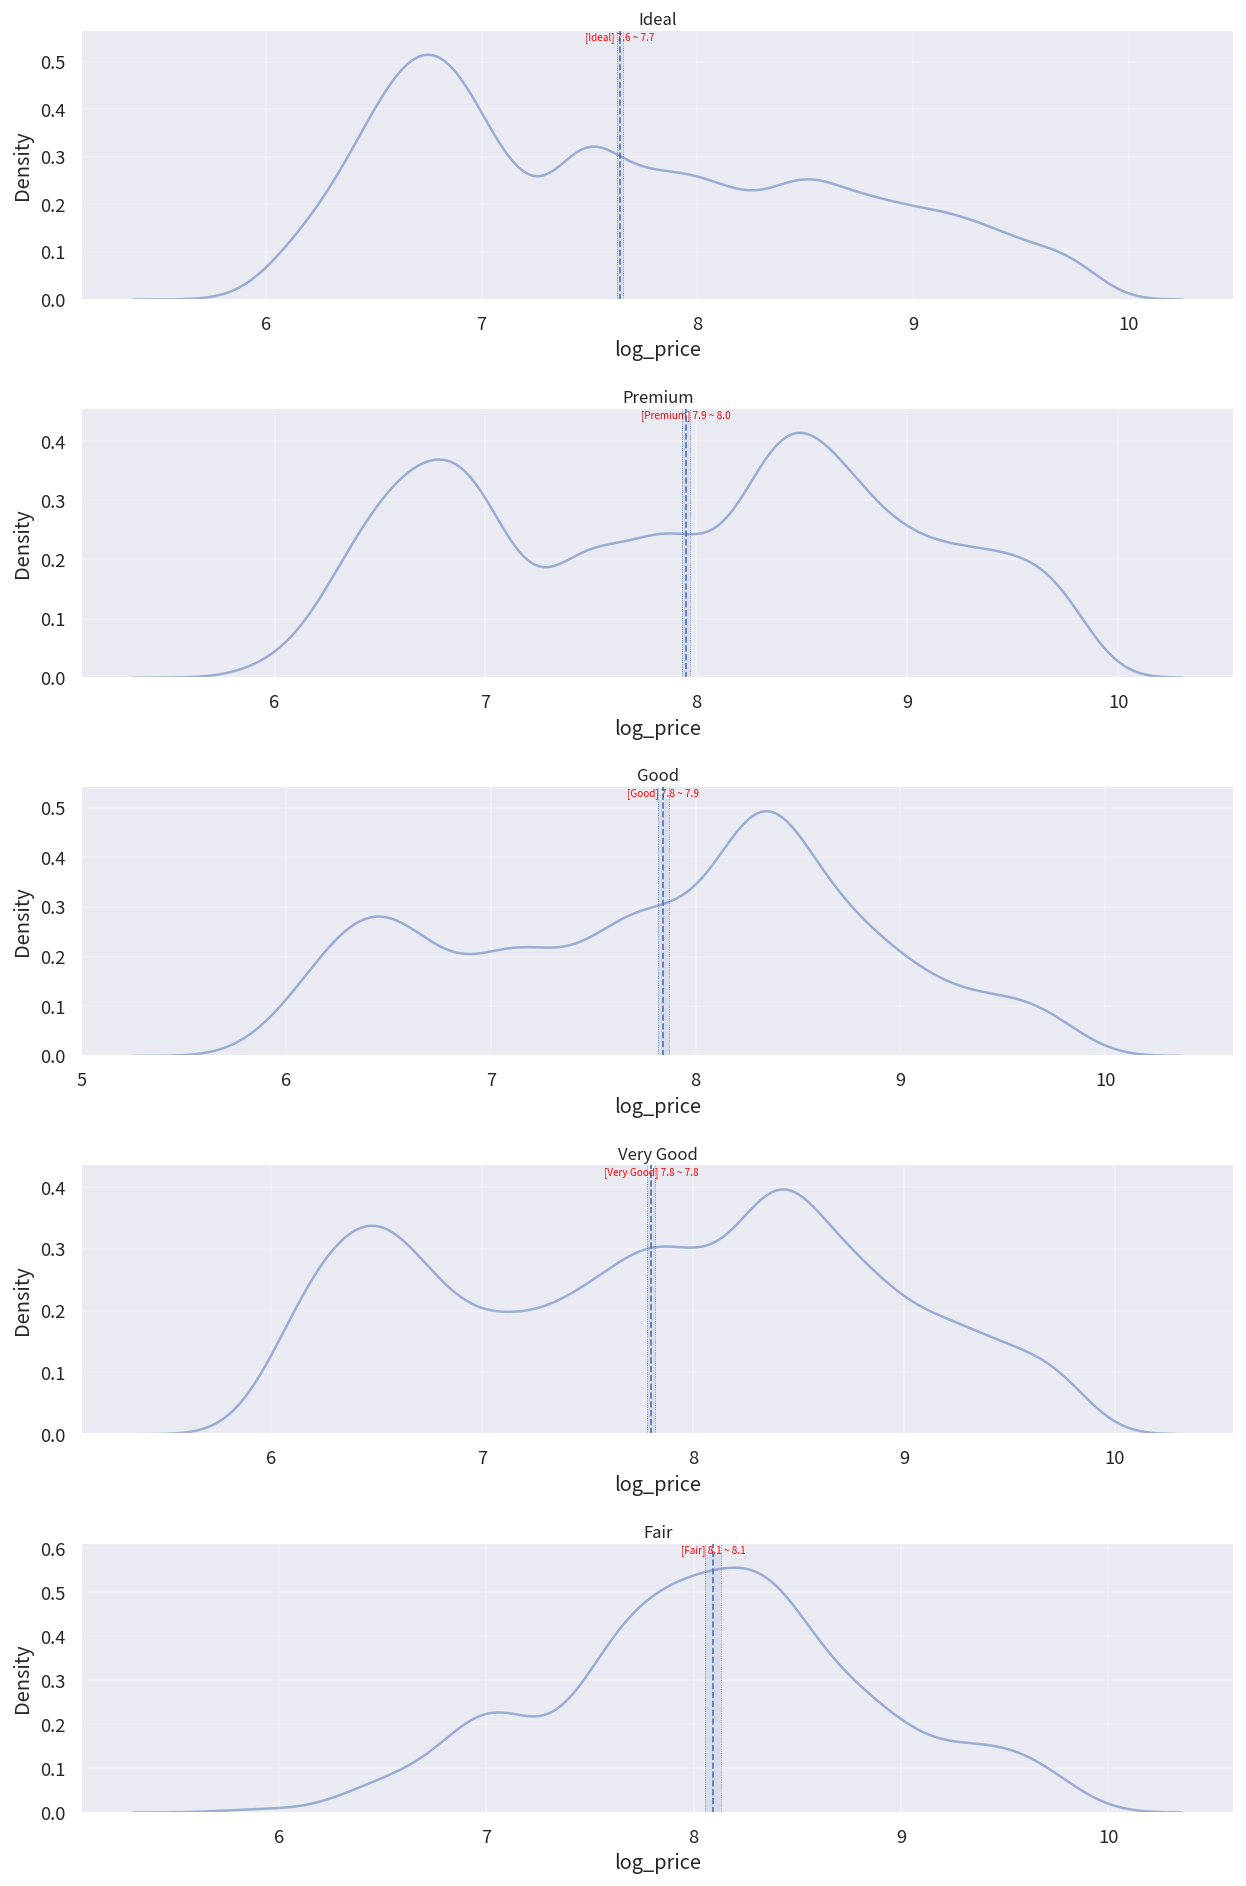

In [155]:
# 확인할 데이터 필드
field = 'log_price'

# 집단을 구분하는 필드(hue)
hue_field = 'cut'

# 요일 종류 구하기
hue_values = df_log[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 5              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = df_log[df_log[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


<정규성 등분산성 검정>

In [156]:
# 요일별 그룹 생성
groups = [(name, grp['log_price']) for name, grp in df_log.groupby('cut')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


C:\Users\itwill\AppData\Local\Temp\ipykernel_20276\1786301501.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [(name, grp['log_price']) for name, grp in df_log.groupby('cut')]


,statistic,p-value,result
field,,,
Ideal,4625.405836,0.000000e+00,False
Premium,9974.910131,0.000000e+00,False
Very Good,4705.594475,0.000000e+00,False
Good,710.350733,5.614333e-155,False
Fair,5.590556,6.109789e-02,True
Levene,122.552036,2.635579e-104,False


> 정규성과 등분산성 충족 x 

In [157]:
if equal_var :
  pg_anova = anova (data = df_log , dv='log_price',between ='cut')

else :
  pg_anova = welch_anova(data = df_log , dv = 'log_price' , between ='cut')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,cut,4,9549.055445,273.801562,3.537749e-223,0.018074


In [158]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 273.802, p-value: 0.000, 대립가설 채택'

> cut 의 다섯개 집단 간의 평균 다이아몬드 가격의 차이를 검정한 결과, 유의수준 0.05 기준에서 통계적으로 유의한 차이가 확인되었다 (P = 0.000)